In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 22 2024

@author: Yaning
"""
# functions for simulating agent data
# this file address is your own
%run Documents/pyro_models/files_to_run/dimitri_shift_model_one_agent.py

import os
import numpy as np
# from turtle import position
import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean
import itertools

/home/yaning/Documents/pyro_models/files_to_run/dimitri_shift_model_one_agent.py:24: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# initialise the param sample range (according to the already inferred results)
mean_u_list = np.linspace(0., 3., 1000)
shift_mean_u_list = np.linspace(-3., 3., 1000)
log_sigma_u_list = np.linspace(0., 3., 1000)
log_shift_sigma_u_list = np.linspace(-2., 0., 1000)
log_sigma_es_list = np.linspace(0., 3., 1000)
log_shift_sigma_es_list = np.linspace(-0.5, 2., 1000)
beta_list = np.linspace(.0001, 10., 1000)

param_list_list = [mean_u_list, shift_mean_u_list, log_sigma_u_list, log_shift_sigma_u_list,
              log_sigma_es_list, log_shift_sigma_es_list, beta_list]

# initialise environment values
repetition = 10
real_delays = [  1.,   2.,   3.,   4.,   6.,   7.,  13.,  14.,  23.,  24.,  29.,
        32.,  45.,  50.,  58.,  62.,  73.,  75., 118., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [20.]

# LL values by percentage of SS
LL_values_p = [1.02  , 1.025 , 1.0255, 1.05  , 1.055 , 1.08  , 1.085 , 1.15  ,
       1.2   , 1.25  , 1.33  , 1.35  , 1.45  , 1.47  , 1.5   , 1.55  ,
       1.65  , 1.7   , 1.83  , 1.85  , 1.9   , 2.05  , 2.07  , 2.25  ,
       2.3   , 2.5   , 2.55  , 2.8   , 2.85  , 3.05  , 3.1   , 3.45  ,
       3.5   , 3.8   , 3.85  ]

LL_values = []
for i in LL_values_p:
    LL_values.append(i*20.)

environment_list = [repetition, delays, SS_values, LL_values]

In [3]:
min(LL_values)

20.4

In [4]:
def sample_param(list):
    mean_u = np.random.choice(list[0])
    shift_mean_u = np.random.choice(list[1])
    log_sigma_u = np.random.choice(list[2])
    log_shift_sigma_u = np.random.choice(list[3])
    log_sigma_es = np.random.choice(list[4])
    log_shift_sigma_es = np.random.choice(list[5])
    beta = np.random.choice(list[6])

    # mean_u = 0.68252325
    # shift_mean_u = 0.34788752
    # log_sigma_u = 1.2042593
    # log_shift_sigma_u = -0.22277783
    # log_sigma_es = 0.97562766
    # log_shift_sigma_es = 0.22311936
    # beta = 0.2533142

    params = [mean_u, shift_mean_u, log_sigma_u, log_shift_sigma_u,
              log_sigma_es, log_shift_sigma_es, beta]
    
    return params

In [5]:
def simulation():
    # params:
    # 0:mean_u
    # 1:shift_mean_u
    # 2:log_sigma_u
    # 3:log_shift_sigma_u
    # 4:log_sigma_es
    # 5:log_shift_sigma_es
    # 6:beta

    # environment_list:
    # 0:repetition
    # 1:delays
    # 2:SS_values
    # 3:LL_values
    # def simulation(params, environment_list):
    # get all the combinations of the arrays
    combinations = list(itertools.product(environment_list[1], environment_list[2], environment_list[3]))
    # every combination appears ten times
    multiplied_array = [x for x in combinations for _ in range(environment_list[0])]
    multiplied_array = np.array(multiplied_array)
    trial_num = multiplied_array.shape[0]

    # create context index cafe:1, 
    context_index = np.zeros((trial_num, 1))
    cafe = np.hstack([multiplied_array, context_index])
    context_index = np.ones((trial_num, 1))
    gamble = np.hstack([multiplied_array, context_index])

    # whole array
    # 0: delays
    # 1: SS_values
    # 2: LL_values
    whole = np.vstack([cafe, gamble])

    # sample parameters
    # sigma_u and sigma_es cannot have too big a difference
    # (what about shifts?)
    # condition_fulfilled = False
    # while not condition_fulfilled:
    #     params = sample_param(param_list_list)
    #     if np.exp(params[2]) - np.exp(params[4]) < 10:
    #         condition_fulfilled = True

    params = sample_param(param_list_list)

    mean_u_cafe = params[0]
    mean_u_gamble = params[0] + params[1]
    mean_u = np.repeat([mean_u_cafe, mean_u_gamble], trial_num)

    sigma_u_cafe = np.exp(params[2])
    sigma_u_gamble = np.exp(params[2] + params[3])
    sigma_u = np.repeat([sigma_u_cafe, sigma_u_gamble], trial_num)

    sigma_es_cafe = np.exp(params[4])
    sigma_es_gamble = np.exp(params[4] + params[5])
    sigma_es = np.repeat([sigma_es_cafe, sigma_es_gamble], trial_num)

    beta = np.repeat([np.exp(params[6]), np.exp(params[6])], trial_num)

    # major calculation 
    inferred_estimation = (mean_u*whole[:,0]*sigma_es**2 + 
                        whole[:,2]*sigma_u**2)/(whole[:,0]*sigma_es**2 + sigma_u**2)


    # change everything to tensor
    whole = torch.tensor(whole)
    inferred_estimation = torch.tensor(inferred_estimation)
    beta = torch.tensor(beta)

    # create softmax and the bernoulli distribution
    softmax_args = torch.stack([beta*inferred_estimation, beta*whole[:,1]])
    p = torch.softmax(softmax_args, dim = 0)[0]
    inferred_response_distr = dist.Bernoulli(probs=p)

    # get one possible predict actions
    inferred_response = inferred_response_distr.sample()

    return inferred_response, params, whole

In [6]:
# get the actions
response_list = [[],[]]
param_list = [[],[]]
percentage_list = [[],[]]

condition_fulfilled = False

while not condition_fulfilled:
    inferred_response, params, whole = simulation()
    choose_LL_percentage = len(list(filter(lambda x: (x == 1), inferred_response))
                               ) / len(inferred_response)
    
    if choose_LL_percentage < 0.5 and len(response_list[0]) < 50:
        response_list[0].append(inferred_response)
        param_list[0].append(params)
        percentage_list[0].append(choose_LL_percentage)
    elif choose_LL_percentage > 0.5 and len(response_list[1]) < 50:
        response_list[1].append(inferred_response)
        param_list[1].append(params)
        percentage_list[1].append(choose_LL_percentage)
    elif len(response_list[0]) == 50 and len(response_list[1]) == 50:
        condition_fulfilled = True
    

In [7]:
# change every list to numpy array
response_list = np.array(response_list)
param_list = np.array(param_list)
percentage_list = np.array(percentage_list)

In [8]:
# add actions into each dataset
data = []
for i in range(response_list.shape[0]):
    for j in range(response_list[i].shape[0]):
        dimension_num = response_list[i][j].shape[0]
        single_data = np.hstack([whole, response_list[i][j].reshape(dimension_num, 1)])
        data.append(single_data)

In [9]:
# data has the shape of (50,14000,5)
# the 5 are:
# 0:delay
# 1:ss_value
# 2:ll_value
# 3:context (0 for cafe, 1 for gamble)
# 4:action (1 for choosing LL)
data = np.array(data)
data = data.reshape(2,50,14000,5)

In [120]:
test = {}
test[1,2] = 5

In [122]:
test.keys()

dict_keys([(1, 2)])

In [113]:
data.shape

(2, 50, 14000, 5)

In [11]:
test_data = data[:,:2]

In [130]:
test_data[0][0]

array([[ 0.1, 20. , 20.4,  0. ,  0. ],
       [ 0.1, 20. , 20.4,  0. ,  0. ],
       [ 0.1, 20. , 20.4,  0. ,  0. ],
       ...,
       [12.2, 20. , 77. ,  1. ,  0. ],
       [12.2, 20. , 77. ,  1. ,  0. ],
       [12.2, 20. , 77. ,  1. ,  0. ]])

Mean ELBO 1966.22: 100%|███████████████████████████████████████| 2000/2000 [00:18<00:00, 107.14it/s]


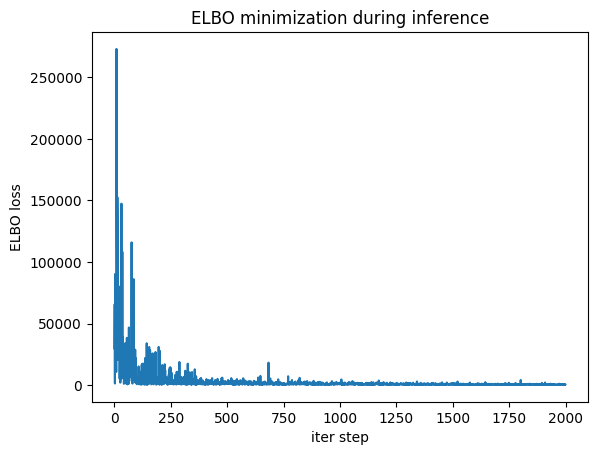

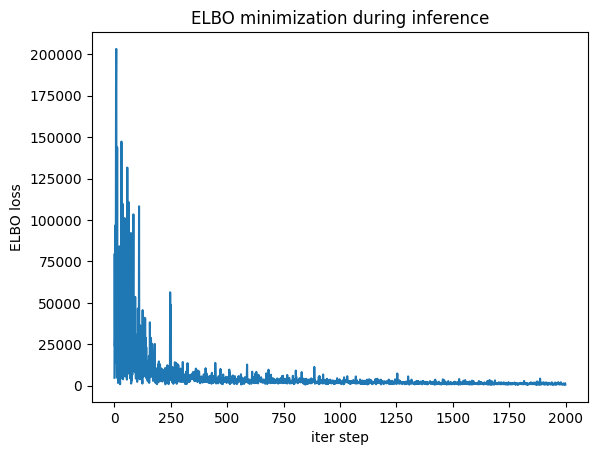

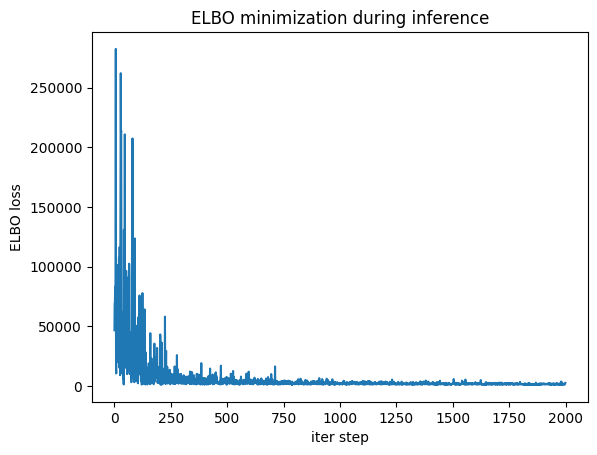

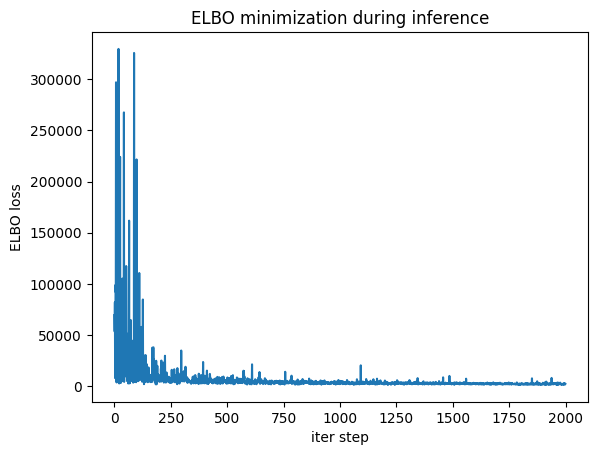

In [12]:
# inference results
pos_dict = {}

# doing inference
# data structure is (2,50,14000,5) with 50% LL choosing grouping
for i in range(test_data.shape[0]):
    for j in range(test_data[i].shape[0]):
        real_data = test_data[i][j]
        real_data = torch.tensor(real_data).to('cuda')
        # this is for running the notebook in our testing framework
        smoke_test = ('CI' in os.environ)
        # the step was 2000
        n_steps = 2 if smoke_test else 2000

        # assert pyro.__version__.startswith('1.8.6')

        # clear the param store in case we're in a REPL
        pyro.clear_param_store()# setup the optimizer
        # the learning rate was 0.0005 , "betas": (0.90, 0.999)
        # tried "n_par":15 in adam params but it does not have this argument
        adam_params = {"lr": 0.01}
        optimizer = Adam(adam_params)
        # setup the inference algorithm
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
        # svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

        loss = []
        pbar = tqdm(range(n_steps), position = 0)
        # do gradient steps
        for step in pbar:
            loss.append(torch.tensor(svi.step(real_data)))
            pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
            # for name, value in pyro.get_param_store().items():
            #     print(name, pyro.param(name))
            if torch.isnan(loss[-1]):
                break

        plt.figure()
        plt.plot(loss)
        plt.xlabel("iter step")
        plt.ylabel("ELBO loss")
        plt.title("ELBO minimization during inference")

        plt.savefig(str(param_list[i][j]) +'.png')

        one_dict = {}
        for name, value in pyro.get_param_store().items():
            one_dict[name] = value
        
        pos_dict[i,j] = one_dict

In [13]:
pos_dict[0,0]['m_locs']

tensor([[ 0.2240, -0.2703,  0.2703, -0.7976, -2.0657, -1.0395,  1.0395]],
       requires_grad=True)

In [20]:
pos_dict

{(0,
  0): {'m_hyp': tensor([ 0.1179, -0.1965,  0.3395, -0.4200, -0.4832, -0.2930,  0.4203, -7.6427,
          -9.2597, -9.6751, -8.8882, -7.1180, -8.5074, -8.6144],
         requires_grad=True), 'scale_tril_hyp': tensor([[ 2.6537e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.9986e-02,  3.8098e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-5.8431e-02, -1.3444e-01,  3.7703e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 2.0101e-02,  1.2934e-01, -1.1118e-01,  3.2191e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  

In [26]:
# change the dictionary to numpy instead of tensor
# because somehow the tensor cannot be save with pickle
numpy_dict = {}
for i in pos_dict.keys():
    temp_dict = {}
    temp_dict['params'] = param_list[i]
    for j in pos_dict[i].keys():
        value = pos_dict[i][j].detach().cpu().numpy()
        temp_dict[j] = value
    numpy_dict[i] = temp_dict



In [ ]:
numpy_dict

In [28]:
# save the dictionary
with open('Documents/pyro_models/files_to_run/results/test.pkl', 'wb') as f:
    pickle.dump(numpy_dict, f)